# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

**NOTE TO THE GRADER: at this point, I should mention that I had to update the `pytorch` and `torchvision` packages in the Udacity GPU workspace to make my model train properly.** For some reason, the training output was coming out as a tuple of tensors instead of as an InceptionOutputs object. Once I updated these packages and the `cudatoolkit` from v8 to v9, everything started training well again.

Did this by opening a new terminal window and running `conda install pytorch torchvision cudatoolkit=9.0 -c pytorch`

In [231]:
# Imports here
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [157]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets

# Means and stdevs common for pre-trained networks
means = [0.485, 0.456, 0.406]
stdevs = [0.229, 0.224, 0.225]

#Inception V3 uses 299x299 images as inputs, not the standard 224x224 of other models
train_transforms = transforms.Compose([transforms.RandomResizedCrop(299),
                                       transforms.ColorJitter(brightness=0.15, 
                                                              contrast=0.15, 
                                                              saturation=0.15, 
                                                              hue=0),
                                       transforms.RandomAffine(30),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(means, 
                                                            stdevs)])


# Data augmentation doesn't get applied to val or test sets
validation_transforms = transforms.Compose([transforms.Resize(512),
                                            transforms.CenterCrop(299),
                                            transforms.ToTensor(),
                                            transforms.Normalize(means,
                                                                 stdevs)])

test_transforms = transforms.Compose([transforms.Resize(512),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize(means, 
                                                            stdevs)])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [317]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
# TODO: Build and train your network
model = models.inception_v3(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:05<00:00, 21022338.09it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [7]:
# Freeze parameters so we don't backprop through the pre-trained feature detector
for param in model.parameters():
    param.requires_grad = False

In [8]:
# Setup new (relatively shallow) classifer network
from collections import OrderedDict

layers = OrderedDict([('hidden1', nn.Linear(2048, 1024)),
                      ('activation1', nn.ReLU()),
                      ('dropout1', nn.Dropout(p=0.2)),
                      ('hidden2', nn.Linear(1024, 512)),
                      ('activation2', nn.ReLU()),
                      ('dropout2', nn.Dropout(p=0.2)),
                      ('hidden3', nn.Linear(512, 256)),
                      ('activation3', nn.ReLU()),
                      ('output', nn.Linear(256, 102)),
                      ('activation_output', nn.LogSoftmax(dim=1))])

classifier = nn.Sequential(layers)
classifier

Sequential(
  (hidden1): Linear(in_features=2048, out_features=1024, bias=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.2)
  (hidden2): Linear(in_features=1024, out_features=512, bias=True)
  (activation2): ReLU()
  (dropout2): Dropout(p=0.2)
  (hidden3): Linear(in_features=512, out_features=256, bias=True)
  (activation3): ReLU()
  (output): Linear(in_features=256, out_features=102, bias=True)
  (activation_output): LogSoftmax()
)

In [9]:
# Set the classifier of our pre-trained model to be our new classifier
# which does NOT have requires_grad = False and thus can be trained,
# unlike our feature detector network
model.fc = classifier
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [10]:
# If GPU is enabled, set device = 'cuda'. Otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

# Actual loss function dictated by model architecture, of course
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)

device

device(type='cuda', index=0)

# TO DO

1. Integrate the code below for keeping track of your best epoch and using its weights in the end
    * Make sure to load the `best_model_wts` state_dict to your model at the end of all epochs
2. Add one or more hidden layers to your existing classifier (I'd recommend at least two more) and some more aggressive dropout (let's double it to `p=0.4`) to see if we can improve training significantly.

In [ ]:
# TODO: keep track of the best accuracy in all of your epochs and reload the state_dict of that one
# at the end
# Code for this from https://medium.com/datadriveninvestor/creating-a-pytorch-image-classifier-da9db139ba80

# Before first epoch
best_model_wts = copy.deepcopy(model.state_dict())
best_accuracy = 0.0

# After validation loop in a given epoch
if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model_wts = copy.deepcopy(model.state_dict())

In [12]:
from time import time
t0 = time()

epochs = 30

from workspace_utils import keep_awake

# Keep GPU session awake until done training
for e in keep_awake(range(epochs)):
    
    # ---------------------- TRAINING ----------------------
    model.train()
    training_loss = 0
    training_batch_counter = 0
    
    for images, labels in trainloader:

        # Move input and label tensors to the GPU or CPU
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        
        # Monitor every 10 batches and final batch
        if training_batch_counter % 10 == 0 or training_batch_counter == (len(trainloader) - 1):
            print(f"Training batch {training_batch_counter}\nLoss = \
            {training_loss/(training_batch_counter + 1)}\n")
            
        training_batch_counter += 1
        
    # ---------------------- VALIDATION ----------------------
    
       
    # turn off gradients for speedup in validation
    with torch.no_grad():

        # set model to evaluation mode and remove un-needed things like Dropout layers
        model.eval()
      
        accuracy = 0
        valid_loss = 0
        val_batch_counter = 0
        
        for images, labels in validloader:
            # Move input and label tensors to the GPU or CPU
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            probs = torch.exp(outputs)

            _, top_class = probs.topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            
            valid_loss += loss.item()
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Monitor every 3 batches and final batch
            if val_batch_counter % 3 == 0 or val_batch_counter == (len(validloader) - 1):
                print(f"Validation batch {val_batch_counter}\nLoss = \
                      {valid_loss/(val_batch_counter + 1)}\n and \
                      accuracy = {accuracy/(val_batch_counter + 1)}\n")
            
            val_batch_counter += 1
            
            
    # Note that normalizing to train/validloader length is due to need to divide by batch size
    # to effectively average the quantity in question
    print(f"For epoch {e+1}/{epochs}...")
    print(f"{round((time()-t0)/60, 3)} minutes since training started")
    print(f"Training loss = {training_loss/len(trainloader)}")
    print(f"Validation loss = {valid_loss/len(validloader)}")
    print(f"Accuracy = {accuracy/len(validloader)}\n\n")
    
    # Save performance results across epochs
    performance = pd.Series([e+1, training_loss/len(trainloader),
                            valid_loss/len(validloader),
                            accuracy/len(validloader)],
                           index = performance_record.columns)
    performance_record.append(performance, ignore_index = True, sort = False)
    
    # set model back to train mode
    model.train()
    
    # Simple early stopping
    #if accuracy/len(validloader) > 0.82: break

Training batch 0
Loss =             4.630075931549072

Training batch 10
Loss =             4.599021651528099

Training batch 20
Loss =             4.587151209513347

Training batch 30
Loss =             4.5677551607931814

Training batch 40
Loss =             4.554961239419332

Training batch 50
Loss =             4.540976645899754

Training batch 60
Loss =             4.525427685409296

Training batch 70
Loss =             4.505955897586446

Training batch 80
Loss =             4.48654908898436

Training batch 90
Loss =             4.464908081096607

Training batch 100
Loss =             4.435434981147842

Training batch 102
Loss =             4.427963423497468

Validation batch 0
Loss =                       4.709080219268799
 and                       accuracy = 0.0

Validation batch 3
Loss =                       4.4813215136528015
 and                       accuracy = 0.0078125

Validation batch 6
Loss =                       4.143697363989694
 and                       accuracy 

Validation batch 12
Loss =                       1.497193836248838
 and                       accuracy = 0.6151923078757066

For epoch 6/30...
17.399 minutes since training started
Training loss = 2.0972759700515895
Validation loss = 1.497193836248838
Accuracy = 0.6151923078757066


Training batch 0
Loss =             2.002833843231201

Training batch 10
Loss =             1.9812714511697942

Training batch 20
Loss =             2.0507045473371233

Training batch 30
Loss =             2.055511220808952

Training batch 40
Loss =             2.0179061860573

Training batch 50
Loss =             2.036121723698635

Training batch 60
Loss =             2.027010003074271

Training batch 70
Loss =             2.005722806487285

Training batch 80
Loss =             2.0017976216327997

Training batch 90
Loss =             1.9893886401103094

Training batch 100
Loss =             1.990009872039946

Training batch 102
Loss =             1.9909755396611482

Validation batch 0
Loss =               

Validation batch 3
Loss =                       1.2427371889352798
 and                       accuracy = 0.65625

Validation batch 6
Loss =                       1.130999505519867
 and                       accuracy = 0.6852678571428571

Validation batch 9
Loss =                       0.9889650374650956
 and                       accuracy = 0.7296875

Validation batch 12
Loss =                       1.108177003952173
 and                       accuracy = 0.7003365388283362

For epoch 12/30...
34.563 minutes since training started
Training loss = 1.5992474197184
Validation loss = 1.108177003952173
Accuracy = 0.7003365388283362


Training batch 0
Loss =             1.580733060836792

Training batch 10
Loss =             1.6144718690352007

Training batch 20
Loss =             1.544016162554423

Training batch 30
Loss =             1.5710592885171213

Training batch 40
Loss =             1.544004425769899

Training batch 50
Loss =             1.5332859123454374

Training batch 60
Loss =  

Training batch 70
Loss =             1.417235941954062

Training batch 80
Loss =             1.4168154604641008

Training batch 90
Loss =             1.4238796535429064

Training batch 100
Loss =             1.434169311334591

Training batch 102
Loss =             1.4341419692178374

Validation batch 0
Loss =                       1.0316720008850098
 and                       accuracy = 0.703125

Validation batch 3
Loss =                       1.0591673254966736
 and                       accuracy = 0.73046875

Validation batch 6
Loss =                       0.931074150971004
 and                       accuracy = 0.7544642857142857

Validation batch 9
Loss =                       0.8436983793973922
 and                       accuracy = 0.7921875

Validation batch 12
Loss =                       0.9796542364817399
 and                       accuracy = 0.7575480754558856

For epoch 18/30...
51.737 minutes since training started
Training loss = 1.4341419692178374
Validation loss = 0.97965

Training batch 0
Loss =             1.38504159450531

Training batch 10
Loss =             1.252122396772558

Training batch 20
Loss =             1.279383327279772

Training batch 30
Loss =             1.3288433724834072

Training batch 40
Loss =             1.341197718934315

Training batch 50
Loss =             1.3439480171484106

Training batch 60
Loss =             1.3389239868179696

Training batch 70
Loss =             1.3389420064402298

Training batch 80
Loss =             1.3472129113880205

Training batch 90
Loss =             1.3470233790167085

Training batch 100
Loss =             1.3519315985169742

Training batch 102
Loss =             1.3488101745114742

Validation batch 0
Loss =                       0.685015082359314
 and                       accuracy = 0.875

Validation batch 3
Loss =                       0.8521656841039658
 and                       accuracy = 0.7734375

Validation batch 6
Loss =                       0.7295396008661815
 and                      

Validation batch 9
Loss =                       0.6158048346638679
 and                       accuracy = 0.8234375

Validation batch 12
Loss =                       0.7399712308095052
 and                       accuracy = 0.8077884637392484

For epoch 29/30...
83.184 minutes since training started
Training loss = 1.246947922174213
Validation loss = 0.7399712308095052
Accuracy = 0.8077884637392484


Training batch 0
Loss =             1.1835381984710693

Training batch 10
Loss =             1.1859056082638828

Training batch 20
Loss =             1.2469160528410048

Training batch 30
Loss =             1.240409508828194

Training batch 40
Loss =             1.2999333433988618

Training batch 50
Loss =             1.3122370359944362

Training batch 60
Loss =             1.3094055945756005

Training batch 70
Loss =             1.3131182915727857

Training batch 80
Loss =             1.313626397539068

Training batch 90
Loss =             1.2991423312124315

Training batch 100
Loss =      

**For reference, Model 1 had an architecture of 3x hidden (2048 -> 1024 -> 512 -> 256 -> 102); all ReLU; no Dropout**

<center> <b> Results of Different Model Runs </b> </center>

Model ID | Deviation from Previous Models | Optimizer | Learning Rate | Number of Epochs | Validation Accuracy | Notes
--- | --- | --- | --- | --- | --- | ---
1 | N/A | Adam | 0.001 | 10 | 0.652 | 
2 | Added Dropout(0.2) on layers 2 and 3 | Adam | 0.001 | 10 | 0.645 | 
3 | Same as Model 2 | Adam | 0.01 | 10 | 0.06 | 
4 | Same as Model 2 | Adam | 0.005 | 10 | 0.06 | Stopped after 2 epochs
5 | Same as Model 2 | Adam | 0.0005 | 10 | 0.723 | 
6 | Same as Model 2 | Adam | 0.0001 | 10 | 0.571 | 
7 | Same as Model 2 | Adam | 0.0005 | 30 | 0.810 | 

**Other items to consider in the future if we want to train this further**

1. Add more hidden layers + dropout
2. Try a different pretrained model (e.g. densenet)
1. Check to see if other optimizers than Adam make sense to try out
    * `optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, momentum=0.9)`
    * `optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov = True)`
4. Change the batch size (64 -> 128). Bigger batches + adaptive learning rates (such as those achieved with rmsprop) [allow you to avoid sampling error of mini-batches causing gradient sign changes that look meaningful but aren't](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
5. Change the data augmentation (maybe include a random selection/ordering transformation?)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
# TODO: Do validation on the test set

# ---------------------- TESTING ----------------------
       
# turn off gradients for speedup in testing
with torch.no_grad():

    # set model to evaluation mode and remove un-needed things like Dropout layers
    model.eval()

    test_accuracy = 0
    test_loss = 0

    for images, labels in testloader:
        # Move input and label tensors to the GPU or CPU
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        probs = torch.exp(outputs)

        _, top_class = probs.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        test_loss += loss.item()
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()



# Note that normalizing to train/validloader length is due to need to divide by batch size
# to effectively average the quantity in question
print(f"Testing loss = {test_loss/len(testloader)}")
print(f"Testing accuracy = {test_accuracy/len(testloader)}\n\n")

# set model back to train mode
model.train()

Testing loss = 0.8524104150441977
Testing accuracy = 0.7742270001998315




Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

**Very nice! We see about 77.4% accuracy with this model!** Let's save this.

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [326]:
# Note that class_to_idx provides the mapping of my folder names to the index used in the model

model.class_to_idx = cat_to_name

checkpoint = {'layers': layers,
              'model_state': model.state_dict(),
             'epoch_count': epochs,
             'opt_state': optimizer.state_dict(),
             'class_to_idx': train_data.class_to_idx,
             'idx_to_class': {v: k for k,v in train_data.class_to_idx.items()}}

torch.save(checkpoint, 'model_checkpoints/checkpoint.pth')

NameError: name 'layers' is not defined

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [313]:
# Imports needed in case we're starting work from this point in the notebook
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models


def load_checkpoint(filepath, device = 'cpu'):
    '''
    Loads your model fully in eval mode
    
    Parameters
    ----------
    filepath: str. Relative filepath from working directory to checkpoint.pth file
    
    device: str. Can be either 'cpu' or 'cuda:0'
    
    
    Returns
    -------
    tuple of (model, optimizer) objects.
    '''
    checkpoint = torch.load(filepath, map_location=device)
    
    # Load the pre-trained model
    model = models.inception_v3(pretrained=True)
    
    # Freeze parameters so we can't backprop through the pre-trained feature detector
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Sequential(checkpoint['layers'])
    model.load_state_dict(checkpoint['model_state'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)
    optimizer.load_state_dict(checkpoint['opt_state'])
    
    model.to(torch.device(device))
    
    model.eval()
    
    return model, optimizer

In [11]:
# Load the model, as needed

model, optimizer = load_checkpoint('checkpoint.pth')

In [12]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [138]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [143]:
def calculate_resize(image, goal_size):
    '''
    Takes a PIL image and outputs the new dimensions it should have in a PyTorch-like
    manner such that the shorter axis is set to goal_size and the long axis is scaled 
    such that the original aspect ratio is maintained. This is intended to be fed into
    Image.resize().
    
    Parameters
    ----------
    image: PIL image object
    
    goal_size: int. Desired minimum dimension size.
    
    
    Returns
    -------
    tuple of ints of the format (new width, new height)
    '''
    
    aspect_ratio = min(image.size) / max(image.size)

    # Get the index of the smaller dimension
    min_ix = image.size.index(min(image.size))

    # width is smaller than height
    if min_ix == 0:
        return (goal_size, int(goal_size/aspect_ratio))
    else:
        return (int(goal_size/aspect_ratio), goal_size)

In [144]:
def calculate_centercrop_box(image, goal_size):
    '''
    Takes a PIL image and outputs the 4-tuple of coordinates needed to perform a centered cropping
    of the image of size goal_size x goal_size. This is intended to be fed into Image.crop().
    
    Parameters
    ----------
    image: PIL image object
    
    goal_size: int. Desired resultant dimension size.
    
    
    Returns
    -------
    4-tuple of ints coordinates of the format (new_width_X, new_width_Y 
                                                new_height_X, new_height_Y)
    '''
    
    width = image.size[0]
    height = image.size[1]
    
    # upperLeft_X, upperLeft_Y, lowerRight_X, lowerRight_Y
    bound_box = [int(0.5*(width - goal_size)), int(0.5*(height - goal_size)),
                int(0.5*(width + goal_size)), int(0.5*(height + goal_size))]
    
    # Check to make sure both dimensions produce goal_size
    bound_box_w = bound_box[2] - bound_box[0]
    bound_box_h = bound_box[3] - bound_box[1]
    
    if bound_box_w != goal_size:
        bound_box[2] -= bound_box_w - goal_size
    
    
    return tuple(bound_box)

In [267]:
import numpy as np
from PIL import Image

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    # Note that, in order to make this similar to my validation and testing batches,
    # I actually need to resize to 512x512 and then crop to 299x299 pixels
    
    # Resize to 512 on the shortest axis, keeping aspect ratio
    new_size = calculate_resize(image, 512)
    image = image.resize(new_size)   
    
    
    # Center-crop the image to 299x299
    crop_size = calculate_centercrop_box(image, 299)
    image = image.crop(crop_size)
    
    
    # Convert image to numpy array
    np_image = np.array(image)
    
    # Scale 0-255 color channel values to 0-1
    np_image = np.divide(np_image, np.array([255]))
    
    # Normalize color channel values
    MEANS = np.array([0.485, 0.456, 0.406])
    STDEVS = np.array([0.229, 0.224, 0.225])
    
    np_image = np.subtract(np_image, MEANS)
    np_image = np.divide(np_image, STDEVS)
    
    # Move color dimension from third to first place, retaining other two dimensions' orders
    # Resulting array should be of shape (3,299,299)
    np_image = np_image.transpose(2,0,1)
    
    # Return numpy array
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [236]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

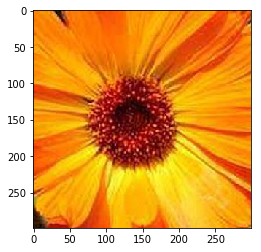

In [269]:
image = Image.open('data/test/5/image_05159.jpg')

# Preprocess the image
im = torch.Tensor(process_image(image))

imshow(im)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [347]:
def predict(image_path, model, topk=5, device='cpu'):
    ''' 
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Parameters
    ----------
    image_path: str. Filepath for image being classified
    
    model: PyTorch model
    
    topk: int. Indicates how many of the highest-probability classes you want predict()
            to return
            
    device: str. Either 'cpu' or 'cuda:0'. Dictates if you'll be using the GPU to predict or the CPU
            Note that prediction is pretty efficient, so no real need to use GPU.
    
    
    Returns
    --------
    tuple of form (top_probabilities, top_class_labels)
    '''
    
    device = torch.device(device)
    
    # Load the Image
    image = Image.open(image_path)
    
    # Preprocess the image
    np_data = process_image(image)
    
    
    # PyTorch expects a 4D tensor for input into Conv2d layers, with a size-1
    # first dimension. Not entirely sure what it is, but probably the batch ID.
    # So let's just give it a new dimension with nothing in it and hope for the best!
    dims = (1,) + np_data.shape
    data = torch.Tensor(np_data).view(dims).to(device)
    
    # TODO: make it so moving of models and inputs to 'device' is done only here,
        # not in earlier load_checkpoint() function
    
    #print(f"Shape of input data is {data.shape}")
    
    # Feedforward the image input to generate prediction probabilities
    with torch.no_grad():

        # set model to evaluation mode and remove un-needed things like Dropout layers
        model.eval()
        
        outputs = model(data)
        probs = torch.exp(outputs)

    top_ps, top_idx = probs.topk(topk, dim = 1)
    
    # Convert to lists for iterating
    top_ps = list(top_ps.numpy()[0])
    top_idx = list(top_idx.numpy()[0])
    
    # Cast labels to strings for easy referencing in model.class_to_idx
    idx_to_class = {v: k for k,v in test_data.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_idx]
        
    return top_ps, top_classes

In [349]:
probs, classes = predict('data/test/1/image_06743.jpg', model, device = 'cpu')
print(probs)
print(classes)

[0.30039874, 0.13981524, 0.10155622, 0.09249932, 0.06175754]
['35', '92', '1', '29', '77']


**Uhhhh...what? 10% probability that this is class zero when that's not a label??**

Glad we're not getting runtime errors anymore, but something is clearly still wrong...

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes